In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from helpers import combine_position_data, log, load_csv, save_csv, calculate_season_average_until_gw
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
import xgboost as xgb
from itertools import combinations
from sklearn.metrics import root_mean_squared_error, r2_score

In [4]:
data_directory = "Fantasy-Premier-League/data"
seasons = ["2022-23", "2023-24", "2024-25"]
positions = ["GK"]
output_file_name = "saves_training_data.csv"

log("Combining position data...", level="INFO")
combine_position_data(data_directory, seasons, positions, output_file_name)

INFO: Combining position data...
INFO: Loaded data from GK_players.csv for season 2022-23.
INFO: Loaded data from GK_players.csv for season 2023-24.
INFO: Loaded data from GK_players.csv for season 2024-25.
INFO: Saved CSV: Fantasy-Premier-League/data/training_data/saves_training_data.csv
INFO: Combined data saved to Fantasy-Premier-League/data/training_data/saves_training_data.csv.


RMSE: 1.5718
R²: 0.4844


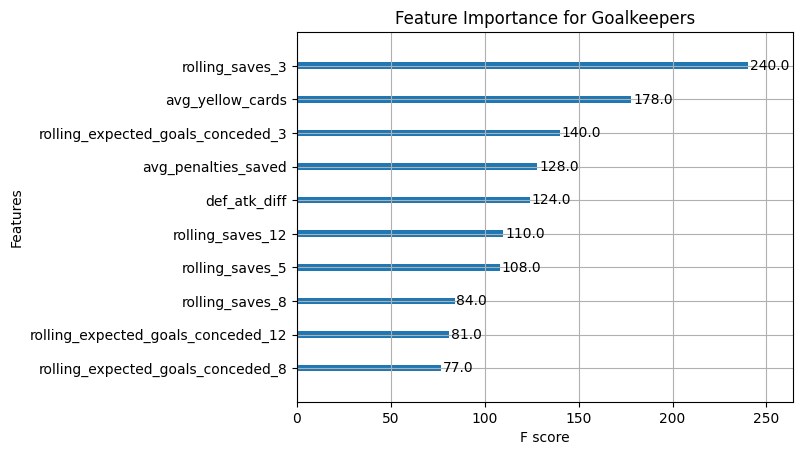

INFO: Model saved at: models/gk_prediction_model.json


In [19]:
training_data_dir = os.path.join(data_directory, "training_data")
training_file = os.path.join(training_data_dir, output_file_name)
gk_data = load_csv(training_file)
if gk_data is None:
    log("Failed to load training data. Exiting.", level="ERROR")
    exit()

# ========================
# Feature Engineering
# ========================
gk_data['was_home'] = gk_data['was_home'].astype(int)
gk_data["def_atk_diff"] = gk_data["own_defense"]-gk_data["opponent_attack"]

rolling_periods = [3, 5, 8, 12]
for period in rolling_periods:
    for feature in ["saves", "clean_sheets", "expected_goals_conceded", "total_points", "minutes", "bps"]:
        gk_data[f"rolling_{feature}_{period}"] = (
            gk_data.groupby("unique_id")[feature]
            .shift(1)
            .rolling(window=period, min_periods=1)
            .mean()
        )

# Average Yellow Cards (only when minutes > 0)
gk_data["avg_yellow_cards"] = (
    gk_data[gk_data["minutes"] > 0]
    .groupby("unique_id")["yellow_cards"]
    .expanding()
    .mean()
    .reset_index(level=0, drop=True)
)

# Penalties Saved (only when minutes > 0)
gk_data["avg_penalties_saved"] = (
    gk_data[gk_data["minutes"] > 0]
    .groupby("unique_id")["penalties_saved"]
    .expanding()
    .mean()
    .reset_index(level=0, drop=True)
)

dummy_columns = ["was_home", "unique_id"]
gk_data = pd.get_dummies(gk_data, columns=dummy_columns)
# Final Feature Set
numerical_features = [
    f"rolling_saves_{period}" for period in rolling_periods
] + [
    f"rolling_clean_sheets_{period}" for period in rolling_periods
] + [
    f"rolling_expected_goals_conceded_{period}" for period in rolling_periods
] + [
    f"rolling_total_points_{period}" for period in rolling_periods
] + [
    f"rolling_minutes_{period}" for period in rolling_periods
] + [
    f"rolling_bps_{period}" for period in rolling_periods
] + [
    "avg_yellow_cards", "avg_penalties_saved", "def_atk_diff", "value"
]
categorical_features = [
    col for col in gk_data.columns if any(col.startswith(f"{dummy_col}_") for dummy_col in dummy_columns)
]
features = numerical_features + categorical_features
target = "total_points"

# ========================
# Train-Test Split
# ========================
X = gk_data[features]
y = gk_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Feature Importance Plot
xgb.plot_importance(model, max_num_features=10)
plt.title("Feature Importance for Goalkeepers")
plt.show()

# Save Model
# ========================
models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "gk_prediction_model.json")
model.save_model(model_path)
log(f"Model saved at: {model_path}", level="INFO")

# ========================
# Optional Hyperparameter Tuning
# ========================
def hyperparameter_tuning(X_train, y_train):
    from sklearn.model_selection import GridSearchCV

    log("Starting hyperparameter tuning...", level="INFO")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    model = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    log(f"Best parameters found: {grid_search.best_params_}", level="INFO")
    log(f"Best RMSE: {-grid_search.best_score_}", level="INFO")
    return grid_search.best_estimator_

# Uncomment to perform tuning
# best_model = hyperparameter_tuning(X_train, y_train)